# Classification des Images de Cancer de la Peau (Bénin ou Malin)

Ce projet vise à effectuer une classification d'images pour distinguer les cas de cancer de la peau bénin et malin. 
Les étapes principales du projet incluent :
1. Segmentation des images avec K-means
2. Extraction des caractéristiques à l'aide de  :
   - Local Binary Pattern (LBP)
   - Percentile de couleur
3. Entraînement et évaluation de plusieurs modèles de classification:
   - Nearest Neighborhood (NN)
   - Nearest Mean Classifier (NMC)
   - Linear Classifier
   - Support Vector Classifier (SVC)

L'objectif final est de sélectionner le modèle offrant la meilleure performance pour prédire les étiquettes d'images.

Auteur : Asmae EL MAHJOUBI
Date : 2020



In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 

import cv2 as cv
from skimage import feature
import seaborn as sns
import imutils
import glob
from scipy import ndimage
import os


In [52]:
# import libeaery pour classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# pour evaluation
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics

## K-means Segmentation

In [53]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        image = cv.imread(os.path.join(folder,filename))
        if image is not None:
            images.append(image)
        return images

In [54]:
images = load_images_from_folder("train")

In [55]:
res1=[]

for i in range(0,len(images)):
    img= images[i]
    imgg= ndimage.median_filter(img, 3)
    img1=imgg.reshape(-1,3)
    img1=np.float32(img1)
    T=img1[:,0]+img1[:,1]+img1[:,2] 
    a=np.argmax(T)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,10,1.0)
    k=2
    ret,label,center=cv2.kmeans(img1,k,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    for i in range(0,np.shape(res)[0]):
        if label[i] == label[a] :
            img1[i] = [0, 0, 0]          
    res1.append(img1.reshape((img.shape)))

In [57]:
d = 0
for i in range(0, len(images)):
    cv.imwrite('segtrain/P-seg_%d.jpg' %d, res1[i])
    d += 1

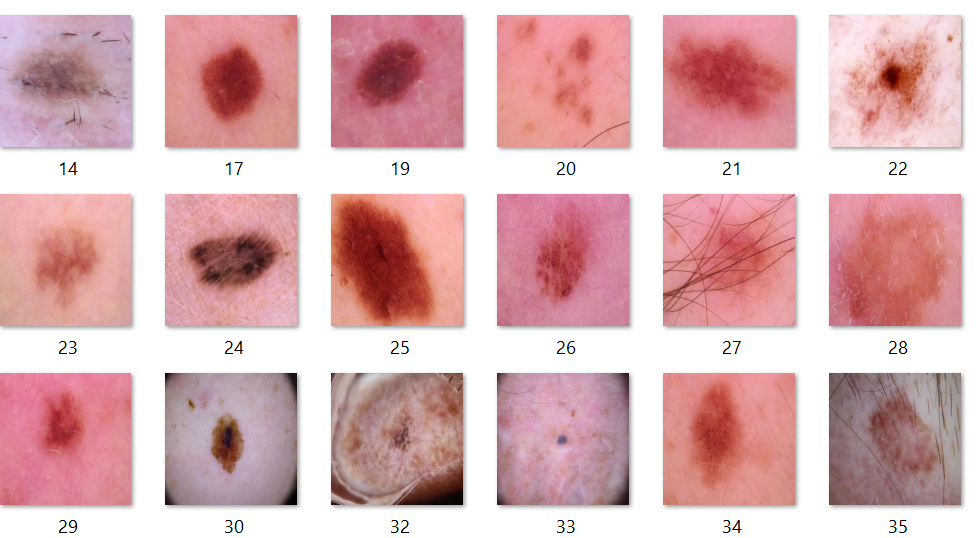

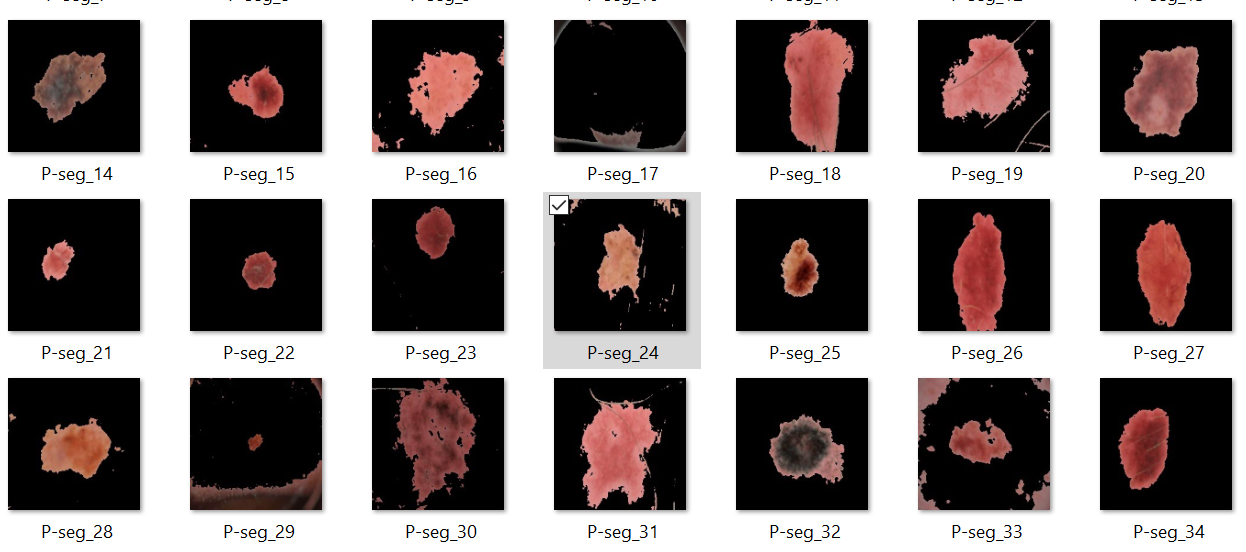

## Feature Extraction

### Local Binary Patterns + Color Percentiles

In [58]:
def lbp_features(img, radius=1, sampling_pixels = 8):
    
   
    if (len(img.shape) > 2):
        img = img.astype(float)
        img = img[:,:,0]*0.3 + img[:,:,1]*0.59 + img[:,:,2]*0.11

    img = img.astype(np.uint8)
    
    i_min = np.min(img)
    i_max = np.max(img)
    if (i_max - i_min != 0):
        img = (img - i_min)/(i_max-i_min)
    
    lbp = feature.local_binary_pattern(img, sampling_pixels, radius, method="uniform")
    
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, sampling_pixels + 3), range=(0, sampling_pixels + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

In [59]:
def colorpercentiles (img):
    
    
    R=img[:,:,0]
    G=img[:,:,1]
    B=img[:,:,2]
    percentiR=np.percentile(R, [25, 50, 75])
    percentiG=np.percentile(G, [25, 50, 75])
    percentiB=np.percentile(B, [25, 50, 75])
    colorpercenti=np.concatenate((percentiR,percentiG,percentiB))
    colorpercentile=colorpercenti
    
    
    return colorpercentile

In [60]:
def createFeatures(Folder):
    
    dataframe=pd.DataFrame() 
    
    
    id=1 
    
   
    for class_fold in glob.glob(Folder+"/*"):
        
        
        
        for imagePath in glob.glob(class_fold+ "/*.jpg"):
                        
            img = cv.imread(imagePath) 
            
            LBP= lbp_features(img, radius = 1, sampling_pixels = 8)
            ColorPerc= colorpercentiles(img)
            features= np.concatenate((LBP,ColorPerc))
            
            df=pd.DataFrame([features])
            df["class_name"] = class_fold.split("\\")[1]
            df["class_id"] = id
            
            dataframe=dataframe.append(df)
            
        id=id+1    
    
    dataframe.index=range(dataframe.index.size) 
    
    return dataframe

In [61]:
dataset = createFeatures("seg_train")
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,class_name,class_id
0,0.032805,0.027902,0.012376,0.036372,0.068080,0.056940,0.027144,0.016641,0.677336,0.044404,...,0.0,50.0,0.0,0.0,57.0,0.0,0.0,110.0,benign,1
1,0.044762,0.036232,0.013931,0.035734,0.044503,0.046277,0.024095,0.017419,0.680106,0.056940,...,0.0,3.0,0.0,0.0,2.0,0.0,0.0,10.0,benign,1
2,0.036611,0.041474,0.026268,0.087333,0.117207,0.135344,0.060706,0.043427,0.373047,0.078583,...,129.0,141.0,0.0,133.0,145.0,0.0,160.0,172.0,benign,1
3,0.023198,0.021783,0.005800,0.017180,0.026248,0.025052,0.010682,0.009546,0.831493,0.029018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign,1
4,0.006816,0.007613,0.004325,0.014310,0.028061,0.025550,0.009805,0.005640,0.885164,0.012715,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign,1


In [62]:
dataset

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,class_name,class_id
0,0.032805,0.027902,0.012376,0.036372,0.068080,0.056940,0.027144,0.016641,0.677336,0.044404,...,0.0,50.0,0.0,0.0,57.0,0.0,0.0,110.0,benign,1
1,0.044762,0.036232,0.013931,0.035734,0.044503,0.046277,0.024095,0.017419,0.680106,0.056940,...,0.0,3.0,0.0,0.0,2.0,0.0,0.0,10.0,benign,1
2,0.036611,0.041474,0.026268,0.087333,0.117207,0.135344,0.060706,0.043427,0.373047,0.078583,...,129.0,141.0,0.0,133.0,145.0,0.0,160.0,172.0,benign,1
3,0.023198,0.021783,0.005800,0.017180,0.026248,0.025052,0.010682,0.009546,0.831493,0.029018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign,1
4,0.006816,0.007613,0.004325,0.014310,0.028061,0.025550,0.009805,0.005640,0.885164,0.012715,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2632,0.012675,0.011659,0.004345,0.010902,0.016223,0.015027,0.008371,0.005540,0.897202,0.018056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,malignant,2
2633,0.018116,0.040497,0.026846,0.131896,0.187659,0.202427,0.096301,0.055784,0.161412,0.079062,...,148.0,160.0,149.0,168.0,177.0,154.0,170.0,180.0,malignant,2
2634,0.073880,0.066227,0.026885,0.066048,0.089405,0.096221,0.055843,0.048449,0.367187,0.109853,...,85.0,107.0,0.0,91.0,109.0,1.0,143.0,157.0,malignant,2
2635,0.063835,0.063357,0.050582,0.094986,0.089445,0.095783,0.055186,0.050981,0.331294,0.104552,...,123.0,130.0,0.0,129.0,138.0,3.0,159.0,170.0,malignant,2


## Classification

#### objectif :  
Nous allons entraîner les modèles suivants : **Nearest Neighborhood (NN)**, **Nearest Mean Classifier (NMC)**, **Linear Classifier**, et **Support Vector Classifier (SVC)**. Ces modèles seront ensuite évalués afin de déterminer celui offrant la meilleure performance pour la prédiction des étiquettes d'images, distinguant entre les cas de cancer de la peau bénin et malin.

In [12]:
X = dataset.drop(["class_name","class_id"], axis = 1)
Y = dataset["class_name"]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)

In [13]:
std_scaler=StandardScaler().fit(X_train) 

X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

print(X_train)

            0         1         2         3         4         5         6   \
2303  0.011878  0.012496  0.008450  0.030014  0.059491  0.043886  0.018555   
2318  0.015386  0.015246  0.008669  0.033960  0.061902  0.048988  0.019691   
636   0.049267  0.046676  0.026527  0.076232  0.119061  0.092833  0.047592   
2320  0.015286  0.019013  0.014648  0.048868  0.076391  0.056780  0.019252   
185   0.003647  0.004644  0.001574  0.005899  0.010483  0.009606  0.004046   
...        ...       ...       ...       ...       ...       ...       ...   
1638  0.017897  0.017917  0.011659  0.044264  0.086336  0.065948  0.024912   
1095  0.011619  0.014230  0.009168  0.032207  0.057458  0.052396  0.020847   
1130  0.033183  0.031788  0.011798  0.043965  0.061623  0.078663  0.041614   
1294  0.005361  0.006258  0.002910  0.012217  0.030054  0.024314  0.008331   
860   0.029397  0.031589  0.018495  0.060945  0.087651  0.081334  0.042191   

            7         8         9    10    11     12   13    14

In [14]:
print(X_train_std)

[[-0.69429587 -0.88224823 -0.66399826 ... -0.44694576 -0.73816575
  -1.12289155]
 [-0.46056392 -0.70485774 -0.64298048 ... -0.44694576 -0.73816575
  -1.08992236]
 [ 1.79707414  1.32227851  1.06901334 ... -0.44694576 -0.05667117
   0.18488661]
 ...
 [ 0.72536007  0.36205607 -0.34299942 ... -0.44694576 -0.73816575
   1.02010628]
 [-1.12855919 -1.28459043 -1.19517491 ... -0.44694576 -0.73816575
  -1.12289155]
 [ 0.47303582  0.34920169  0.29899826 ... -0.44694576 -0.7268075
   0.58051698]]


In [15]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8,8))
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes )
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#### KNN

In [16]:
grid_params = {'n_neighbors': np.arange(2,15)}

score = "accuracy"

knn = KNeighborsClassifier()

clf = GridSearchCV(knn, grid_params, scoring = score, cv = 5)
clf.fit(X_train_std,Y_train)

y_pred_knn = clf.predict(X_test_std)

In [17]:
print(y_pred_knn)

['malignant' 'benign' 'malignant' 'benign' 'malignant' 'malignant'
 'benign' 'benign' 'benign' 'benign' 'malignant' 'benign' 'malignant'
 'benign' 'benign' 'benign' 'malignant' 'benign' 'benign' 'benign'
 'benign' 'malignant' 'benign' 'benign' 'benign' 'benign' 'malignant'
 'benign' 'malignant' 'benign' 'malignant' 'benign' 'benign' 'benign'
 'benign' 'malignant' 'benign' 'malignant' 'malignant' 'benign'
 'malignant' 'benign' 'malignant' 'malignant' 'malignant' 'benign'
 'benign' 'benign' 'benign' 'benign' 'benign' 'malignant' 'benign'
 'malignant' 'malignant' 'benign' 'benign' 'benign' 'malignant' 'benign'
 'benign' 'benign' 'malignant' 'malignant' 'benign' 'benign' 'malignant'
 'malignant' 'benign' 'benign' 'malignant' 'benign' 'benign' 'malignant'
 'malignant' 'benign' 'benign' 'malignant' 'benign' 'benign' 'benign'
 'malignant' 'malignant' 'benign' 'malignant' 'benign' 'malignant'
 'malignant' 'benign' 'benign' 'benign' 'benign' 'benign' 'malignant'
 'malignant' 'malignant' 'benign

Accuracy Score KNN =  0.7436868686868687


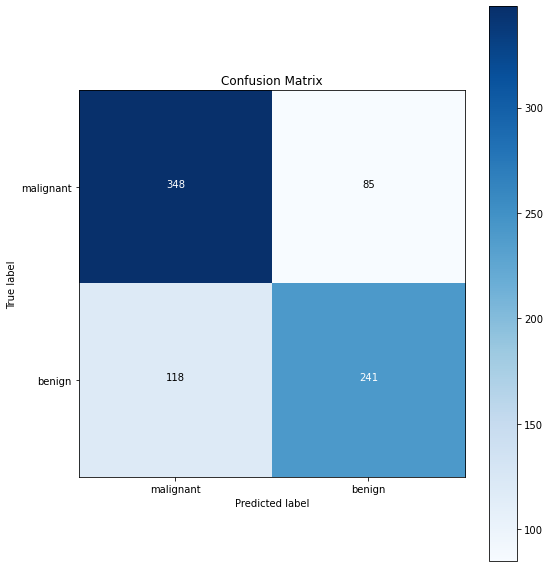

In [18]:
acc_score_knn = accuracy_score(Y_test, y_pred_knn) #precision

matrix_conf_knn = confusion_matrix(Y_test,y_pred_knn) #matrice de confusion

print("Accuracy Score KNN = ", acc_score_knn)
plot_confusion_matrix(matrix_conf_knn, classes=["malignant", "benign"])

In [19]:
from sklearn.metrics import recall_score

In [20]:
recall_knn = recall_score(Y_test, y_pred_knn, average='macro')
print("Recall Score KNN = ", recall_knn)

Recall Score KNN =  0.7375021711580152


In [21]:
from sklearn.metrics import classification_report

In [22]:
print(classification_report(Y_test, y_pred_knn))

              precision    recall  f1-score   support

      benign       0.75      0.80      0.77       433
   malignant       0.74      0.67      0.70       359

    accuracy                           0.74       792
   macro avg       0.74      0.74      0.74       792
weighted avg       0.74      0.74      0.74       792



#### NMC

In [23]:
nmc = NearestCentroid(metric='euclidean', shrink_threshold = None)

nmc.fit(X_train_std,Y_train)
y_pred_nmc = nmc.predict(X_test_std)

print(y_pred_nmc)

['malignant' 'benign' 'benign' 'malignant' 'malignant' 'malignant'
 'benign' 'benign' 'benign' 'benign' 'malignant' 'malignant' 'malignant'
 'benign' 'benign' 'malignant' 'malignant' 'benign' 'benign' 'benign'
 'benign' 'malignant' 'malignant' 'benign' 'benign' 'benign' 'malignant'
 'benign' 'malignant' 'benign' 'benign' 'benign' 'benign' 'benign'
 'benign' 'malignant' 'malignant' 'malignant' 'malignant' 'benign'
 'benign' 'benign' 'malignant' 'malignant' 'malignant' 'benign'
 'malignant' 'benign' 'benign' 'benign' 'benign' 'malignant' 'benign'
 'malignant' 'malignant' 'benign' 'malignant' 'benign' 'malignant'
 'benign' 'benign' 'benign' 'malignant' 'malignant' 'benign' 'benign'
 'malignant' 'malignant' 'benign' 'benign' 'benign' 'benign' 'benign'
 'malignant' 'malignant' 'benign' 'benign' 'malignant' 'malignant'
 'benign' 'malignant' 'malignant' 'malignant' 'benign' 'malignant'
 'benign' 'malignant' 'malignant' 'benign' 'benign' 'benign' 'benign'
 'benign' 'malignant' 'malignant' 'mal

Accuracy Score NMC =  0.6792929292929293


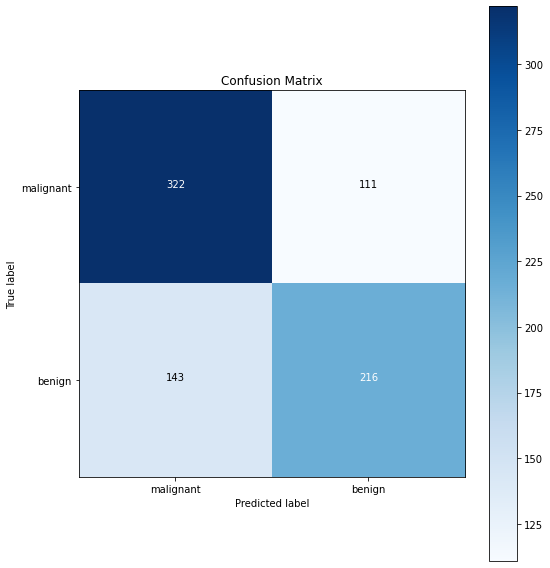

In [24]:
acc_score_nmc = accuracy_score(Y_test, y_pred_nmc) #precision

matrix_conf_nmc = confusion_matrix(Y_test, y_pred_nmc) #matrice de confusion

print("Accuracy Score NMC = ", acc_score_nmc)
plot_confusion_matrix(matrix_conf_nmc, classes = ["malignant", "benign"])

In [25]:
recall_nmc = recall_score(Y_test, y_pred_nmc, average='macro')
print("Recall Score NMC = ", recall_nmc)

Recall Score NMC =  0.6726601349656153


In [26]:
print(classification_report(Y_test, y_pred_nmc))

              precision    recall  f1-score   support

      benign       0.69      0.74      0.72       433
   malignant       0.66      0.60      0.63       359

    accuracy                           0.68       792
   macro avg       0.68      0.67      0.67       792
weighted avg       0.68      0.68      0.68       792



#### Logistic Classifiers

In [27]:
lr = LogisticRegression()
lr.fit(X_train_std, Y_train)
y_pred_lr = lr.predict(X_test_std)


C:\Users\EL mahjoubi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
print(y_pred_lr)

['malignant' 'benign' 'benign' 'benign' 'malignant' 'malignant' 'benign'
 'benign' 'benign' 'benign' 'malignant' 'malignant' 'malignant' 'benign'
 'benign' 'malignant' 'malignant' 'benign' 'benign' 'benign' 'benign'
 'benign' 'benign' 'benign' 'benign' 'benign' 'malignant' 'benign'
 'benign' 'benign' 'benign' 'benign' 'benign' 'benign' 'benign'
 'malignant' 'benign' 'benign' 'malignant' 'benign' 'malignant' 'benign'
 'malignant' 'malignant' 'benign' 'benign' 'malignant' 'benign' 'benign'
 'benign' 'benign' 'malignant' 'benign' 'malignant' 'malignant' 'benign'
 'benign' 'benign' 'malignant' 'benign' 'benign' 'benign' 'malignant'
 'malignant' 'benign' 'benign' 'malignant' 'malignant' 'benign' 'benign'
 'benign' 'benign' 'benign' 'malignant' 'malignant' 'benign' 'benign'
 'malignant' 'benign' 'benign' 'malignant' 'benign' 'malignant' 'benign'
 'malignant' 'benign' 'malignant' 'malignant' 'benign' 'benign' 'benign'
 'benign' 'benign' 'malignant' 'malignant' 'malignant' 'benign' 'benign'
 '

Accuracy Score Linear classifiers =  0.7323232323232324


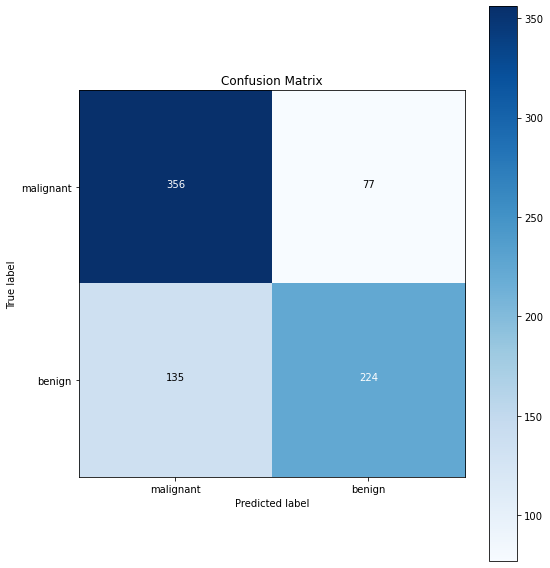

In [29]:
acc_score_lr = accuracy_score(Y_test, y_pred_lr) #precision

matrix_conf_lr = confusion_matrix(Y_test, y_pred_lr) #matrice de confusion

print("Accuracy Score Linear classifiers = ", acc_score_lr)
plot_confusion_matrix(matrix_conf_lr, classes=["malignant", "benign"])

In [30]:
recall_lr = recall_score(Y_test, y_pred_lr, average='macro')
print("Recall Score LR = ", recall_lr)

Recall Score LR =  0.7230631662238576


In [31]:
print(classification_report(Y_test, y_pred_lr))

              precision    recall  f1-score   support

      benign       0.73      0.82      0.77       433
   malignant       0.74      0.62      0.68       359

    accuracy                           0.73       792
   macro avg       0.73      0.72      0.72       792
weighted avg       0.73      0.73      0.73       792



### SVM

In [32]:
svc = SVC(C = 1, kernel = "rbf", gamma = 1, max_iter = -1, probability = True)

svc.fit(X_train_std,Y_train)
y_pred_svm=svc.predict(X_test_std)

print(y_pred_svm)

['malignant' 'benign' 'malignant' 'malignant' 'malignant' 'malignant'
 'benign' 'benign' 'benign' 'benign' 'malignant' 'benign' 'malignant'
 'benign' 'benign' 'benign' 'malignant' 'benign' 'malignant' 'benign'
 'benign' 'malignant' 'benign' 'benign' 'benign' 'benign' 'malignant'
 'benign' 'malignant' 'benign' 'malignant' 'benign' 'malignant' 'benign'
 'benign' 'malignant' 'benign' 'malignant' 'malignant' 'benign'
 'malignant' 'benign' 'malignant' 'malignant' 'malignant' 'benign'
 'benign' 'benign' 'benign' 'benign' 'benign' 'malignant' 'benign'
 'malignant' 'malignant' 'benign' 'benign' 'benign' 'malignant' 'benign'
 'benign' 'benign' 'malignant' 'malignant' 'benign' 'malignant'
 'malignant' 'malignant' 'malignant' 'benign' 'malignant' 'malignant'
 'benign' 'malignant' 'malignant' 'benign' 'benign' 'malignant' 'benign'
 'benign' 'malignant' 'malignant' 'malignant' 'benign' 'malignant'
 'benign' 'malignant' 'malignant' 'benign' 'benign' 'benign' 'benign'
 'benign' 'malignant' 'malignant

Accuracy Score SVM =  0.7651515151515151


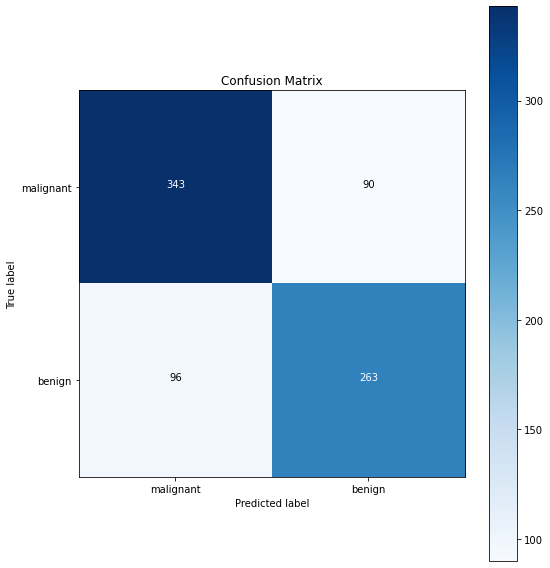

In [33]:
acc_score_svm = accuracy_score(Y_test,y_pred_svm) 
matrix_conf_svm  =confusion_matrix(Y_test,y_pred_svm) 

print("Accuracy Score SVM = ", acc_score_svm)
plot_confusion_matrix(matrix_conf_svm, classes = ["malignant", "benign"])

In [34]:
recall_svm = recall_score(Y_test, y_pred_svm, average='macro')
print("Recall Score SVC = ", recall_svm)

Recall Score SVC =  0.7623691676262649


In [35]:
print(classification_report(Y_test, y_pred_svm))

              precision    recall  f1-score   support

      benign       0.78      0.79      0.79       433
   malignant       0.75      0.73      0.74       359

    accuracy                           0.77       792
   macro avg       0.76      0.76      0.76       792
weighted avg       0.76      0.77      0.76       792



### Evaluation

C:\Users\EL mahjoubi\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Accuracy Score')

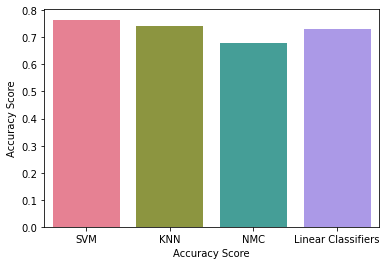

In [36]:
res = pd.DataFrame({"Accuracy Score":[acc_score_svm, acc_score_knn, acc_score_nmc, acc_score_lr],"Algorithm":['SVM',  'KNN', 'NMC', 'Linear Classifiers']})

g = sns.barplot("Algorithm", "Accuracy Score", data = res, palette='husl', orient = "v")
g.set_xlabel("Accuracy Score")

Les résultats présentés dans le graphes ci-dessus montrent que l’algorithme SVM est meilleur que KNN, NMC et linear classifier.

# Prédiction des étiquettes des images

In [40]:
images = load_images_from_folder("C:/Users/EL mahjoubi/Desktop/Skin cancer classification using k-means clustering/Predict")

In [41]:
res1 = []

for i in range(0, len(images)):
    img= images[i]
    imgg= ndimage.median_filter(img, 3)
    img1=imgg.reshape(-1,3)
    img1=np.float32(img1)
    T = img1[:,0]+img1[:,1]+img1[:,2] 
    a = np.argmax(T)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER,10,1.0)
    k = 2
    ret,label,center = cv.kmeans(img1,k,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    for i in range(0,np.shape(res)[0]):
        if label[i] == label[a] :
            img1[i] = [0, 0, 0]          
    res1.append(img1.reshape((img.shape)))

In [42]:
d = 0
for i in range(0, len(images)):
    cv.imwrite('segpredict/P-seg_%d.jpg' %d, res1[i])
    d += 1

In [43]:
def createFeatures2(Folder):
    
    dataframe = pd.DataFrame()
    

    for imagePath in glob.glob(Folder+ "/*.jpg"):
        
        img = cv.imread(imagePath) 
        LBP= lbp_features(img, radius=1, sampling_pixels=8)
        ColorPerc= colorpercentiles(img)
        features= np.concatenate((LBP,ColorPerc))

        df=pd.DataFrame([features])
        df["name"]=imagePath.split("\\")[1]
            
            
        dataframe=dataframe.append(df)
        
    dataframe.index=range(dataframe.index.size)
    
    return dataframe

In [44]:
dossiers = "seg_predict"
data = createFeatures2(dossiers)

In [45]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,name
0,0.035874,0.028699,0.010144,0.037050,0.055485,0.043646,0.018475,0.012675,0.714266,0.043686,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,5.0,P-seg_0.jpg
1,0.022800,0.018455,0.008669,0.028101,0.049287,0.039481,0.016901,0.010643,0.775550,0.030114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,P-seg_1.jpg
2,0.007832,0.008331,0.005859,0.023796,0.053113,0.037986,0.014389,0.006836,0.827647,0.014210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P-seg_10.jpg
3,0.013652,0.018515,0.012456,0.053571,0.095823,0.079341,0.033462,0.017319,0.645886,0.029974,0.0,0.0,48.0,0.0,0.0,52.0,0.0,0.0,119.0,P-seg_11.jpg
4,0.019053,0.016123,0.006457,0.019113,0.029875,0.023278,0.010224,0.006896,0.847836,0.021146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P-seg_12.jpg


In [46]:
data_test = data.drop(["name"],axis=1)
print(data_test)

          0         1         2         3         4         5         6   \
0   0.035874  0.028699  0.010144  0.037050  0.055485  0.043646  0.018475   
1   0.022800  0.018455  0.008669  0.028101  0.049287  0.039481  0.016901   
2   0.007832  0.008331  0.005859  0.023796  0.053113  0.037986  0.014389   
3   0.013652  0.018515  0.012456  0.053571  0.095823  0.079341  0.033462   
4   0.019053  0.016123  0.006457  0.019113  0.029875  0.023278  0.010224   
..       ...       ...       ...       ...       ...       ...       ...   
66  0.038624  0.035455  0.015007  0.049326  0.075574  0.078504  0.033442   
67  0.024693  0.022182  0.008450  0.028679  0.062679  0.039820  0.016602   
68  0.035774  0.029815  0.013532  0.045301  0.121791  0.062062  0.024434   
69  0.017618  0.017160  0.008111  0.025411  0.039023  0.038485  0.018734   
70  0.019930  0.021445  0.015406  0.053412  0.088887  0.067861  0.030612   

          7         8         9    10   11    12   13   14     15   16   17  \
0   0.01

In [47]:
svc.fit(X,Y)

y_pred = svc.predict(data_test)
y_pred

array(['malignant', 'benign', 'benign', 'malignant', 'benign',
       'malignant', 'malignant', 'malignant', 'benign', 'benign',
       'benign', 'malignant', 'malignant', 'benign', 'malignant',
       'malignant', 'benign', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'benign', 'malignant', 'malignant',
       'benign', 'malignant', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'benign', 'malignant', 'benign',
       'benign', 'malignant', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'malignant', 'benign', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'benign', 'benign', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'benign', 'malignant', 'malignant', 'benign',
       'malignant', 'benign', 'malignant'], dtype=object)

In [48]:
for imagePath in glob.glob(dossiers+ "/*.jpg"):
     image = cv.imread(imagePath)

In [49]:
dic = {"Name": data["name"].values, "Classe": y_pred}

df_result = pd.DataFrame(dic)

df_result.to_csv("Prediction.csv", index=False)